In [3]:
#!/usr/bin/python

'''
@author:Jamiree Harrison
        jamiree@ucsb.edu
        June 8th, 2023
'''


#######################################

#Import modules required by Acis
import os
import urllib
import urllib.request
import json
import csv
#Import plotting tools
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
#Import plotting tools
import base64
import pandas as pd
import geopandas
import matplotlib.tri as tri
from scipy import interpolate
from scipy.interpolate import griddata
from numpy import linalg as LA
from pydmd import DMD
from geopandas import GeoDataFrame
from shapely.geometry import Point
import us_boundaries as usb

In [4]:
def get_grid_z(file, grid_x, grid_y):

        # Read the CSV file into a DataFrame
        data = pd.read_csv(file)

        # Extract the values from column 1 and column 2
        column1 = data['latitude']
        column2 = data['longitude']
        column3 = data['brightness']

        points = np.zeros((len(column2),2))
        points[:,0] = column2
        points[:,1] = column1

        column4 = np.zeros((len(column3),1))

        
        grid_z = griddata(points, column3, (grid_x, grid_y), method='linear')

        return grid_z

In [5]:
'''
inputs: m by n data matrix, m states, n timepoints
outputs: m by m matrix A 

'''
def DMD_matrix(data):


        print('shape of data', np.shape(data))
        m , n = np.shape(data)

        X_0 = data[:, 0:n-1]

        X_1 = data[:, 1:n]

        

        # Compute the SVD
        U, S, VT = np.linalg.svd(X_0,  full_matrices=True)
        
        true_s = np.zeros((U.shape[1], VT.shape[0]))
        true_s_inv = np.zeros((U.shape[1], VT.shape[0]))
        
        true_s[:S.size, :S.size] = np.diag(S)
        true_s_inv[:S.size, :S.size] = np.linalg.inv(np.diag(S))

        S_pinv = np.linalg.pinv(true_s)

        print('shape of U', np.shape(U))
        print('shape of X_1', np.shape(X_1))
        print('shape of VT.T', np.shape(VT.T[:, :n]))
        print('shape of S_inv', np.shape(S_pinv))
        print('shape of true_s_inv', np.shape(true_s_inv))

        A = U @ X_1 @ VT.T @ S_pinv
#         A = U @ X_1 @ VT.T @ true_s_inv.T

        return A 

In [6]:
def run_dmd(data,t):
    

        # Now we have the temporal snapshots in the input matrix rows: 
        # we can easily create a new DMD instance and exploit it in order to 
        # compute the decomposition on the data. Since the snapshots must be arranged 
        # by columns, in this case we need to transpose the matrix.



        dmd = DMD(svd_rank=100)

        dmd.fit(data.T)


        # The `dmd` object contains the principal information about the decomposition:
        # - the attribute `modes` is a 2D numpy array where the columns are the low-rank structures individuated; 
        # - the attribute `dynamics` is a 2D numpy array where the rows refer to the time evolution of each mode;
        # - the attribute `eigs` refers to the eigenvalues of the low dimensional operator;
        # - the attribute `reconstructed_data` refers to the approximated system evolution.
        # 
        # Moreover, some helpful methods for the graphical representation are provided.

        # Thanks to the eigenvalues, we can check if the modes are stable or not: 
        # if an eigenvalue is on the unit circle, the corresponding 
        # mode will be stable; while if an eigenvalue is inside or outside the 
        # unit circle, the mode will converge or diverge, respectively. 
        # From the following plot, we can note that the two modes are stable.

        ##################

        # for eig in dmd.eigs:
        #         print('Eigenvalue {}: distance from unit circle {}'.format(eig, np.abs(np.sqrt(eig.imag**2+eig.real**2) - 1)))

        # dmd.plot_eigs(show_axes=True, show_unit_circle=True)

        ##################

        # # We can plot the modes and the dynamics:
        # for mode in dmd.modes.T:
        #         print('mode=', mode.real)


        # Finally, we can reconstruct the original dataset as the product of modes 
        # and dynamics. We plot the evolution of each mode to emphasize their 
        # similarity with the input functions and we plot the reconstructed data.

        fig = plt.figure(figsize=(17,6))

        # for n, mode, dynamic in zip(range(131, 133), dmd.modes.T, dmd.dynamics):
        #     plt.plot(t, (mode.reshape(-1, 1).dot(dynamic.reshape(1, -1))).real.T)
        #     plt.title('YFP vs time')
        #     plt.xlabel('time (hours)')
        #     plt.ylabel('YFP')
        #     plt.show()

        # plt.plot(t, dmd.reconstructed_data.T.real[-1,:], label = 'DMD')
        # plt.plot(t,data[-1,:], 'o--', label = 'real')
        # plt.title('Brightness for a given (longitude, latitude)')
        # plt.xlabel('year')
        # plt.ylabel('Brightness (K)')
        # plt.legend()
        # plt.xticks(np.arange(min(t), max(t)+1, 1.0))


        # We can also plot the absolute error between the approximated data and the original one.
        error = abs(data-dmd.reconstructed_data.T).real
        # error = np.reshape(error, (len(t),))   

        print('norm of error = ',LA.norm((data[-1,:] - dmd.reconstructed_data.T[-1,:]).real))


        grid_x, grid_y = np.meshgrid(np.linspace(-127, -70, num_gridpts),
                                     np.linspace(24, 50, num_gridpts), indexing='ij')

        # grid_z = data[:,-1]
        # grid_z = grid_z.reshape((num_gridpts,num_gridpts))

        grid_z = dmd.reconstructed_data.T[:,-1]


        grid_z = np.array(grid_z.reshape((num_gridpts,num_gridpts)), dtype=np.float)

        
        print(np.shape(grid_z))

        fig1, ax1 = plt.subplots()

        # geometry = [Point(xy) for xy in zip(column2,column1)]

        # gdf = GeoDataFrame(data, geometry = geometry)

        # world_gdf = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
        # world_gdf = world_gdf[world_gdf['continent'] == 'North America']
        # #world_gdf.plot(ax=ax, facecolor=[0,0,0,0], edgecolor='k')
        # #gdf.plot(ax = world_gdf.plot(figsize = (10, 10)), color = 'red', markersize = 10)
        # # gdf.plot(ax = ax, color = 'red', markersize = 10)
        # ax1.set()

        # # Draw United States boundaries overlaying fires

        # states = ['Alabama', 'Alaska', 'American Samoa', 'Arizona', 'Arkansas', 
        #             'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 
        #             'Florida', 'Georgia', 'Guam', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 
        #             'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 
        #             'Minnesota', 'Minor Outlying Islands', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 
        #             'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 
        #             'North Dakota', 'Northern Mariana Islands', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 
        #             'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 
        #             'Texas', 'U.S. Virgin Islands', 'Utah', 'Vermont', 'Virginia', 'Washington', 
        #             'West Virginia', 'Wisconsin', 'Wyoming']

        # for s in states:
        #    if (s != 'American Samoa') and (s != 'District of Columbia') and (s != 'Guam') and (s != 'Hawaii') and (s != 'Minor Outlying Islands') and (s != 'Northern Mariana Islands') and (s != 'Puerto Rico') and (s != 'U.S. Virgin Islands'):
        #       usb.draw_state(ax1, s, edgecolor='w')

        
        cb = ax1.pcolormesh(grid_x, grid_y, grid_z, cmap = "seismic", vmin=-0, vmax=510)
        cbar = plt.colorbar(cb)
        plt.xlim([-127, -70])
        plt.ylim([24, 50])
        plt.xlabel('longitude')
        plt.ylabel('latitude')
        plt.title('Brightness across USA in Kelvin (2022)')
        plt.grid()
        plt.show()
            
        # plt.plot(t,error, 'o--')
        # plt.title('pointwise absolute error')
        # plt.xlabel('time (hours)')
        # plt.ylabel('YFP')
        # plt.xticks(np.arange(min(t), max(t)+1, 1.0))
        # plt.show()
        
        

In [12]:
# Folder path containing CSV files
folder_path = os.path.expanduser("~/Desktop/gsmmc_fire_2023/modis_fire_data")

num_gridpts = 40

grid_x, grid_y = np.meshgrid(np.linspace(-127, -70, num_gridpts),
                                     np.linspace(24, 50, num_gridpts), indexing='ij')

z_data = np.empty((num_gridpts*num_gridpts , 23))

###################


# Iterate through files in the folder
i = 0

for filename in sorted(os.listdir(folder_path)):
    if filename.endswith('States.csv'):  # Check if file has .csv extension
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame
        data = pd.read_csv(file_path)
        grid_z = get_grid_z(file_path, grid_x, grid_y)

        grid_z = np.array(grid_z)
        grid_z_flat = grid_z.flatten()

        z_data[:,i] = grid_z_flat

        i = i+1

t = np.linspace(0,22, 23)

mask = np.isnan(z_data) 

z_data[mask] = 300 # miinimum brightness value 



In [13]:
# # Read the CSV file into a DataFrame
# data = pd.read_csv('modis_2021_United_States.csv')

# # Extract the values from column 1 and column 2
# column1 = data['latitude']
# column2 = data['longitude']
# column3 = data['brightness']

# fig2, ax2 = plt.subplots()
# cb = ax2.tricontourf(column2, column1, column3, 100, cmap = "seismic")
# cbar = plt.colorbar(cb)
# plt.xlim([-127, -70])
# plt.ylim([24, 50])
# plt.xlabel('longitude')
# plt.ylabel('latitude')
# plt.title('Brightness as a function of Temperature in Kelvin (2022)')
# plt.grid()

# matplotlib.rcParams.update({'font.size': 24})

# run_dmd(z_data, t)


shape of data (1600, 23)
shape of U (1600, 1600)
shape of X_1 (1600, 22)
shape of VT.T (22, 22)
shape of S_inv (22, 1600)
shape of true_s_inv (1600, 22)
shape of A (1600, 1600)
[[ 9.82964578e-01  1.93901870e-01  4.65143929e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 3.58326028e-02 -1.03054787e-01  1.16702793e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.93134695e-02  2.08708823e-01  2.34539627e-01 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [-4.13739929e-04 -5.62456963e-04  1.02859789e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.13739929e-04 -5.62456963e-04  1.02859789e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-4.13739929e-04 -5.62456963e-04  1.02859789e-03 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]]
(40, 40)


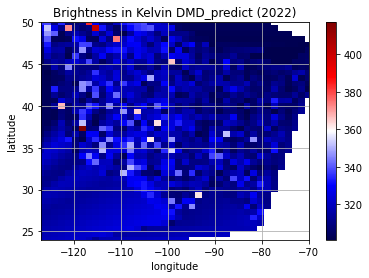

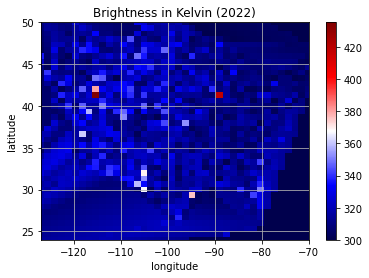

In [14]:
A = DMD_matrix(z_data)

print('shape of A', np.shape(A))

print(A)

Brightness_approx_2022 = A @ z_data[:,21]


grid_z_approx = np.array(Brightness_approx_2022.reshape((num_gridpts, num_gridpts)), dtype=float)
grid_z_true = np.array(z_data[:,21].reshape((num_gridpts, num_gridpts)), dtype=float)
        
print(np.shape(grid_z))



fig1, ax1 = plt.subplots()
cb = ax1.pcolormesh(grid_x, grid_y, grid_z, cmap = "seismic")
cbar = plt.colorbar(cb)
plt.xlim([-127, -70])
plt.ylim([24, 50])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Brightness in Kelvin DMD_predict (2022)')
plt.grid()

fig2, ax2 = plt.subplots()
cb = ax2.pcolormesh(grid_x, grid_y, grid_z_true, cmap = "seismic")
cbar = plt.colorbar(cb)
plt.xlim([-127, -70])
plt.ylim([24, 50])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Brightness in Kelvin (2022)')
plt.grid()

# for i in range(len(column3)):
#         if column3[i] >= 400:
#                 column4[i] = 1



# # visuals of 'fire here'
# # all the data points block out where the fires are
# fig2, ax2 = plt.subplots()
# cb2 = ax2.scatter(column2, column1, c= column4, s=20*column4)
# plt.xlim([-127, -70])
# plt.ylim([24, 50])
# plt.xlabel('longitude')
# plt.ylabel('latitude')
# plt.title('Fire occured here')
# plt.grid()


# Display the plot
plt.show()

